PassengerId & Ticket - don't add value to the prediction since they are unique identification values

Pclass - important ordinal attribute

Fare - important ordinal attribute

Name - we could infer new attributes from 'Mr', 'Mrs', 'Miss', 'Master' (see other values)

Sex - nominal

Age - quantitative

SibSp - # of siblings/spouse

Parch - # of parents/childrens

Cabin - cabin type: to exclude since ~80% empty

Embarked - port of embarcation

Survived - to predict

https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def summary_missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['# of Missing', 'Percent'])
    return missing_data

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


In [3]:
raw = pd.read_csv('./data/train.csv')
rawt = pd.read_csv('./data/test.csv')

In [4]:
raw.shape, rawt.shape, raw.shape[0] + rawt.shape[0]

((891, 12), (418, 11), 1309)

### Concat training and test data for preprocessing

In [5]:
brk = raw.shape[0]
data_cleaner = pd.concat([raw.copy(), rawt.copy()], ignore_index=True)
data_cleaner.shape

(1309, 12)

### Index 890 splits the training and test data

In [6]:
data_cleaner.iloc[brk-2:brk+2, :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
889,26.0,C148,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369
890,32.0,NaN,Q,7.7500,"Dooley, Mr. Patrick",0,891,3,male,0,0.0,370376
891,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
892,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272


# Missing values

- How to deal with **Age**?
    - Fill mode? median by groups?
    
    
- Who are the ones with no **Embarked** and **Fare**?
    - Decide what to do
    - Fill the **Embarked** and **Fare** type of other similar persons (by age? parch? pclass?)

In [7]:
summary_missing_data(data_cleaner.drop(columns=['Survived'])).head(5)

,# of Missing,Percent
Cabin,1014,0.774637
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
Ticket,0,0.000000


## Drop attributes that don't add value to our predictor
- **PassengerId** and **Ticket** don't add value to the prediction since they are unique identification values
- **Cabin** to exclude since ~80% empty

In [8]:
data_cleaner = data_cleaner.drop(columns=['Cabin', 'Ticket'])

## Fill NAs

In [9]:
fillers = {
    'Age': raw['Age'].mode()[0],
    'Embarked': raw['Embarked'].mode()[0],
    'Fare': raw['Fare'].mode()[0]
}
data_cleaner = data_cleaner.fillna(fillers)
summary_missing_data( data_cleaner.drop(columns=['Survived']) ).head()

,# of Missing,Percent
SibSp,0,0.0
Sex,0,0.0
Pclass,0,0.0
PassengerId,0,0.0
Parch,0,0.0


# Title

- Identify from the **Name** meaningful socio-economic status as 'Mr', 'Mrs', 'Dr', 'Master', etc appears. Do OneHot encoder on them, then delete column Name

In [10]:
u_titles = []
for n in data_cleaner['Name']:
    s = n.split(',')
    status = s[1].split('.')
    u_titles.append(status[0].strip())
titles = list(set(u_titles))
pd.Series(u_titles).value_counts()
# titles

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Ms                2
Mlle              2
the Countess      1
Don               1
Lady              1
Sir               1
Dona              1
Mme               1
Capt              1
Jonkheer          1
dtype: int64

In [11]:
titles = ['Mr', 'Miss', 'Mrs', 'Master']

In [12]:
titles_encoded = []
for a_title in titles:
    titles_encoded.append(pd.DataFrame([ 1 if n.find(a_title+'.') >= 0 else 0 for n in data_cleaner['Name'] ], columns=[a_title]))

# Family Size

- Combine **SibSp** and **Parch** into one feature **FamilySize**

In [13]:
data_cleaner.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0


In [14]:
data_cleaner['FamilySize'] = data_cleaner['SibSp'] + data_cleaner['Parch']

In [15]:
datasetdummy = pd.concat([data_cleaner, *titles_encoded], axis=1)
datasetdummy = datasetdummy.drop(columns=['Name'])
datasetdummy.shape
datasetdummy.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master
0,22.0,S,7.2500,0,1,3,male,1,0.0,1,1,0,0,0
1,38.0,C,71.2833,0,2,1,female,1,1.0,1,0,0,1,0
2,26.0,S,7.9250,0,3,3,female,0,1.0,0,0,1,0,0
3,35.0,S,53.1000,0,4,1,female,1,1.0,1,0,0,1,0
4,35.0,S,8.0500,0,5,3,male,0,0.0,0,1,0,0,0


## LabelEncode features

- **Embarked** and **Sex**

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(datasetdummy['Sex'])
print(encoder.classes_, [n for n in range(len(encoder.classes_))])
datasetdummy['Sex'] = encoder.transform(datasetdummy['Sex'])

encoder = LabelEncoder().fit(datasetdummy['Embarked'])
print(encoder.classes_, [n for n in range(len(encoder.classes_))])
datasetdummy['Embarked'] = encoder.transform(datasetdummy['Embarked'])

datasetdummy = datasetdummy.rename(columns={'Sex':'Sex_code'})
datasetdummy.head()

['female' 'male'] [0, 1]
['C' 'Q' 'S'] [0, 1, 2]


,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex_code,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master
0,22.0,2,7.2500,0,1,3,1,1,0.0,1,1,0,0,0
1,38.0,0,71.2833,0,2,1,0,1,1.0,1,0,0,1,0
2,26.0,2,7.9250,0,3,3,0,0,1.0,0,0,1,0,0
3,35.0,2,53.1000,0,4,1,0,1,1.0,1,0,0,1,0
4,35.0,2,8.0500,0,5,3,1,0,0.0,0,1,0,0,0


## What about $0 Fares?

In [17]:
datasetdummy[ datasetdummy['Fare'] < 1 ]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex_code,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master
179,36.0,2,0.0,0,180,3,1,0,0.0,0,1,0,0,0
263,40.0,2,0.0,0,264,1,1,0,0.0,0,1,0,0,0
271,25.0,2,0.0,0,272,3,1,0,1.0,0,1,0,0,0
277,24.0,2,0.0,0,278,2,1,0,0.0,0,1,0,0,0
302,19.0,2,0.0,0,303,3,1,0,0.0,0,1,0,0,0
413,24.0,2,0.0,0,414,2,1,0,0.0,0,1,0,0,0
466,24.0,2,0.0,0,467,2,1,0,0.0,0,1,0,0,0
481,24.0,2,0.0,0,482,2,1,0,0.0,0,1,0,0,0
597,49.0,2,0.0,0,598,3,1,0,0.0,0,1,0,0,0
633,24.0,2,0.0,0,634,1,1,0,0.0,0,1,0,0,0


In [18]:
def plot_cross_tab(x, y, xlabel, colnames=None):
    pd.crosstab(x, y, colnames=colnames).plot(kind='bar')
    plt.title('Frequency of ' + str(xlabel))
    plt.xlabel(xlabel)
    plt.ylabel('Frequency');

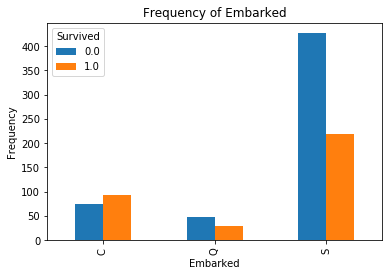

In [19]:
plot_cross_tab(data_cleaner['Embarked'], data_cleaner['Survived'], 'Embarked')

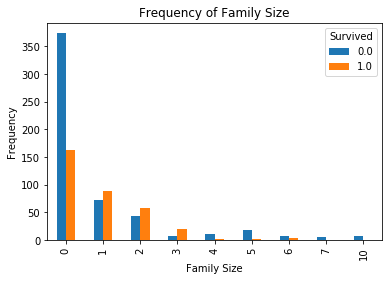

In [20]:
plot_cross_tab(data_cleaner['FamilySize'], data_cleaner['Survived'], 'Family Size')

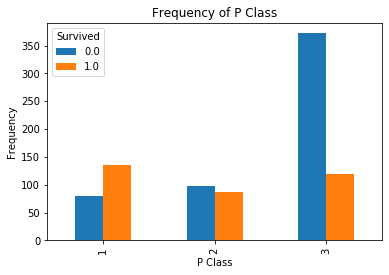

In [21]:
plot_cross_tab(data_cleaner['Pclass'], data_cleaner['Survived'], 'P Class')

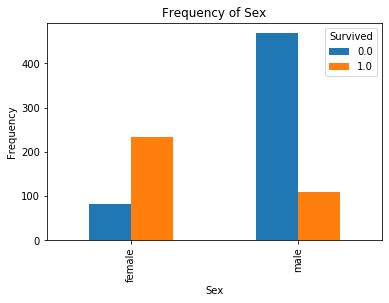

In [22]:
plot_cross_tab( data_cleaner['Sex'], data_cleaner['Survived'], xlabel='Sex' )

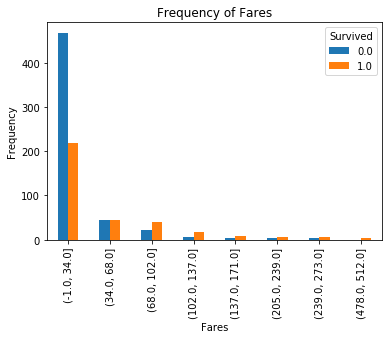

In [23]:
plot_cross_tab( pd.cut( data_cleaner['Fare'], bins=15, precision=0 ), data_cleaner['Survived'], xlabel='Fares' )

# Correlation

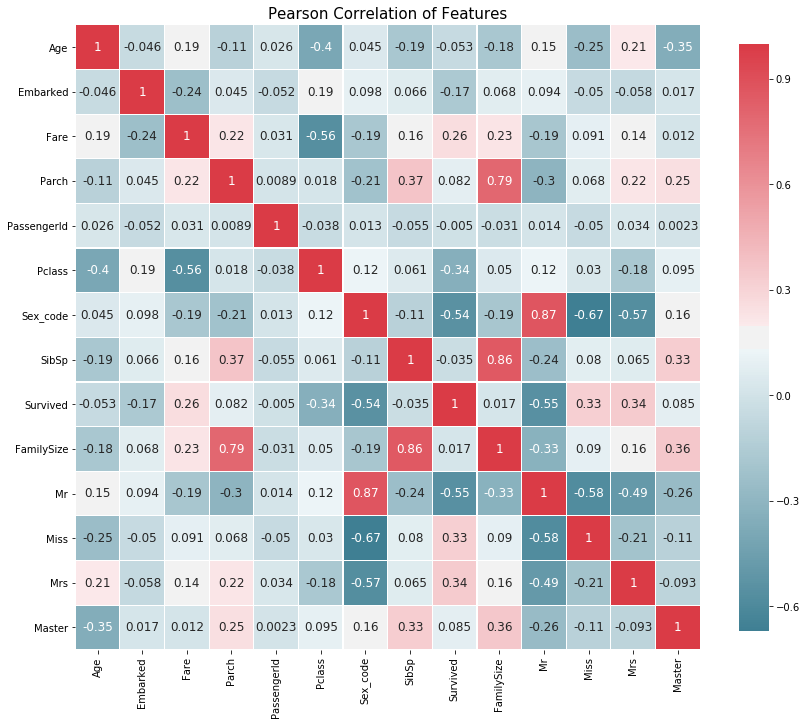

In [24]:
correlation_heatmap(datasetdummy)

In [25]:
datasetdummy.iloc[brk-2:brk+2, :].head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex_code,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master
889,26.0,0,30.0000,0,890,1,1,0,1.0,0,1,0,0,0
890,32.0,1,7.7500,0,891,3,1,0,0.0,0,1,0,0,0
891,34.5,1,7.8292,0,892,3,1,0,NaN,0,1,0,0,0
892,47.0,2,7.0000,0,893,3,0,1,NaN,1,0,0,1,0


In [26]:
print('Train shape \t\t{}'.format(raw.shape))
print('Test shape \t\t{}'.format(rawt.shape))
# print('Combined Raw shape \t{}'.format(rawfull.shape))
print('Dummy shape \t\t{}'.format(datasetdummy.shape))

Train shape 		(891, 12)
Test shape 		(418, 11)
Dummy shape 		(1309, 14)


## Split training and test set and save

In [27]:
datatrain = datasetdummy.iloc[0:brk,:]
datatrain.shape

(891, 14)

In [28]:
datatest = datasetdummy.iloc[brk:,:]
datatest = datatest.drop(columns=['Survived'])
datatest.shape

(418, 13)

## Save output file

In [29]:
datatrain.to_csv('cl_train.csv', index=False)
datatest.to_csv('cl_test.csv', index=False)